In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import data_reader as dr

In [18]:
data, source = dr.read('kospi.csv')

Loading data from file /home/changhyun/workspace/cxk858/dataset/kospi.csv...



In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1220 entries, 0 to 1224
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1220 non-null   object 
 1   Open                 1220 non-null   float64
 2   High                 1220 non-null   float64
 3   Low                  1220 non-null   float64
 4   Close                1220 non-null   float64
 5   Adj Close            1220 non-null   float64
 6   Volume               1220 non-null   float64
 7   Daily_log_return     1219 non-null   float64
 8   Daily_trading_range  1220 non-null   float64
 9   Log_Volume_change    1219 non-null   float64
 10  Daily_return         1219 non-null   float64
 11  Target               1198 non-null   float64
dtypes: float64(11), object(1)
memory usage: 123.9+ KB


In [20]:
data = data.drop(['Date', 'Adj Close', 'Open', 'High', 'Close', 'Volume', 'Low','Daily_return'], axis=1)

In [21]:
from arch import arch_model

In [22]:
log_return = data['Daily_log_return']
log_return = log_return.dropna()

In [23]:
gm = arch_model(log_return, p=1,q=1, mean='AR', dist='normal')

gm_res = gm.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9268.590461548647
Iteration:      2,   Func. Count:     15,   Neg. LLF: 728790.9615923933
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2007.278205307991
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1831.0194296094437
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1574.3461820402351
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1574.091089570334
Iteration:      7,   Func. Count:     49,   Neg. LLF: 1574.0902646308793
Iteration:      8,   Func. Count:     54,   Neg. LLF: 1574.09020922096
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1574.0901989439094
Iteration:     10,   Func. Count:     63,   Neg. LLF: 1574.0901989439117
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1574.0901989439094
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


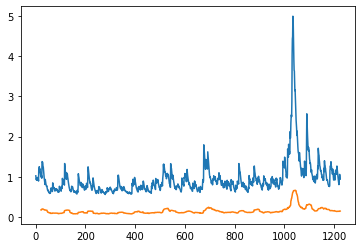

In [24]:
plt.plot(gm_res.conditional_volatility)
plt.plot(data['Target'])
plt.show()

In [25]:
rolling_pred = {}
split = int(len(log_return))*0.8

In [26]:
window = 22
for i in range(window, len(log_return)):
    model = arch_model(log_return, p=1,q=1, mean='AR')
    model_fit = model.fit(first_obs=i-window, last_obs=i, disp='off')
    pred = model_fit.forecast(horizon=1).variance
    fcast = pred.iloc[i-1]
    rolling_pred[fcast.name] = fcast

/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [27]:
print(pd.DataFrame(rolling_pred).T)

           h.1
22    1.192901
23    1.252116
24    1.158734
25    1.884618
26    1.884949
...        ...
1219  0.934543
1220  1.020997
1221  1.099276
1222  0.862357
1223  0.706787

[1197 rows x 1 columns]


In [36]:
egm_pred = {}

In [37]:
for i in range(window, split):
    emodel = arch_model(log_return, p=1,q=1,o=1, vol='egarch', mean='AR', dist='skewt')
    emodel_fit = emodel.fit(first_obs=i-window, last_obs=i, disp='off', options={'maxiter':500})
    e_pred = emodel_fit.forecast(horizon=1).variance
    efcast = e_pred.iloc[i-1]
    egm_pred[efcast.name] = efcast

/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds duri

In [38]:
print(pd.DataFrame(egm_pred).T)

               h.1
22    1.207489e-06
23    5.692345e+00
24    2.711262e+06
25    5.538668e-01
26    4.670247e+10
...            ...
1219  6.947843e+00
1220  2.866011e+00
1221  9.389615e+00
1222  1.045277e+00
1223  1.074166e+00

[1197 rows x 1 columns]
